In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import os
import sys
import math
import time
import numpy as np
import tensorflow as tf
from tqdm import tqdm, trange
from matplotlib import pyplot as plt
from tensorflow import keras as K

print("tf: {}".format(tf.version.VERSION))
print("tf.keras: {}".format(K.__version__))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf: 2.1.0
tf.keras: 2.2.4-tf
Num GPUs Available:  1


In [2]:
sys.path.append('../SketchRNN_tf2')
from sketchrnn import models, dataset, utils

In [3]:
data_class = 'airplane' #@param ["cat","eye","rabbit"]

data = np.load(f'../data/quickdraw/{data_class}.npz',encoding='latin1',allow_pickle=True)

data_train = [dataset.cleanup(d) for d in data['train']]
data_valid = [dataset.cleanup(d) for d in data['valid']]
data_test = [dataset.cleanup(d) for d in data['test']]

hps = {
    "max_seq_len": max(map(len, np.concatenate([data['train'], data['valid'], data['test']]))),
    'batch_size': 100,
    "num_batches": math.ceil(len(data_train) / 100),
    "epochs": 100,
    "recurrent_dropout_prob": 0.1, ## 0.0 for gpu lstm
    "enc_rnn_size": 256,
    "dec_rnn_size": 512,
    "z_size": 128,
    "num_mixture": 20,
    "learning_rate": 0.001,
    "min_learning_rate": 0.00001,
    "decay_rate": 0.9999,
    "grad_clip": 1.0,
    'kl_tolerance': 0.2,
    'kl_decay_rate': 0.99995,
    "kl_weight": 0.5,
    'kl_weight_start': 0.01,
}

In [4]:
sketchrnn = models.SketchRNN(hps)
sketchrnn.models['full'].summary()

initial_epoch, initial_loss = 10, 0.30
checkpoint = os.path.join(f'../data/sketchrnn/{data_class}/checkpoints', 'sketch_rnn_{}_weights.{:02d}_{:.2f}.hdf5').format(data_class, initial_epoch, initial_loss)
sketchrnn.load_weights(checkpoint)

Model: "sketchrnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 99, 5)]      0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 128), (None, 667904      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
initial_state (Model)           [(None, 512), (None, 132096      encoder[1][0]                    
__________________________________________________________________________________________

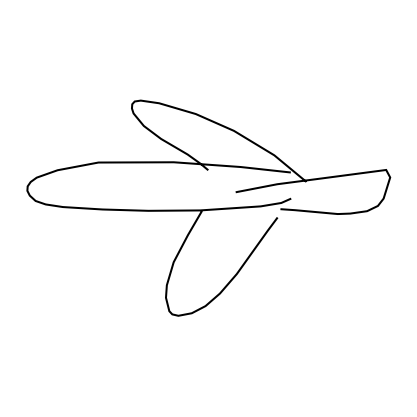

In [20]:
fig, ax = plt.subplots(figsize=(3, 3))

strokes = sketchrnn.sample(temperature=0.01)
utils.plot_strokes(ax, utils.to_normal_strokes(strokes))

utils.plt_show()